In [1]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np

from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval



Using TensorFlow backend.


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [4]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [5]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

### data augm

In [8]:
x_all = np.load("/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u15_d30.npy")
x_all2 = np.load("/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u15_d30.npy")

x_train1 = x_all[mask_train]
x_val = x_all[mask_test]
#x_unb = x_all[mask_unlabeled]

x_train2 = x_all2[mask_train]


x_train = np.concatenate([x_train1,x_train2])
if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))

x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
#x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (8678, 45, 45, 1) (8678,)
Objetos de validación: (1918, 45, 45, 1) (1918,)


## canales

In [6]:
!ls /work/work_teamEXOPLANET/MTF_margarita/no_invertidos

MTF_u10_d10.npy  MTF_u10_d30.npy  MTF_u15_d20.npy  MTF_u5_d15.npy
MTF_u10_d15.npy  MTF_u15_d10.npy  MTF_u15_d30.npy  MTF_u5_d20.npy
MTF_u10_d20.npy  MTF_u15_d15.npy  MTF_u5_d10.npy   MTF_u5_d30.npy


In [37]:
x_all1 = np.load("/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u15_d30.npy")
x_all2 = np.load("/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u15_d30.npy")

x_all = np.concatenate([x_all1[:,:,:,None],x_all2[:,:,:,None]], axis=-1)

x_train = x_all[mask_train]
x_val = x_all[mask_test]
#x_unb = x_all[mask_unlabeled]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 45, 45, 2) (4339,)
Objetos de validación: (1918, 45, 45, 2) (1918,)


In [40]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.86762575 1.18003941]


In [25]:
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2025)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               518656    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 519,937
Trainable params: 519,425
Non-trainable params: 512
_________________________________________________________________


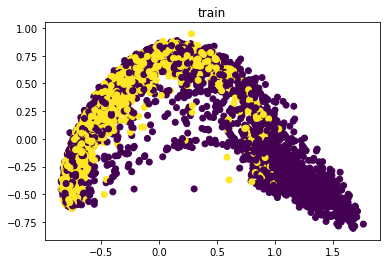

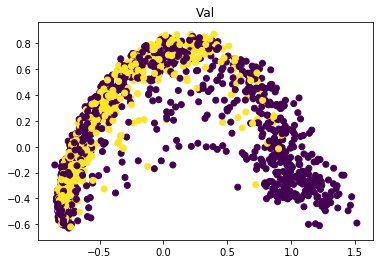

In [15]:
from sklearn.decomposition import PCA
dims_r = np.prod(x_train.shape[1:])

model = PCA(2)
plot_x = model.fit_transform(x_train.reshape([x_train.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_train, cmap='viridis') #morado es falso positivo
plt.title("train")
plt.show()

plot_x = model.transform(x_val.reshape([x_val.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_val, cmap='viridis') #morado es falso positivo
plt.title("Val")
plt.show()

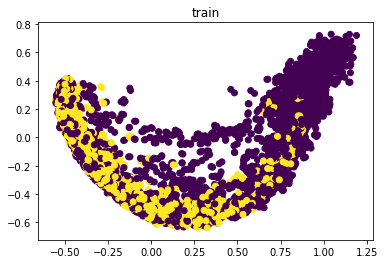

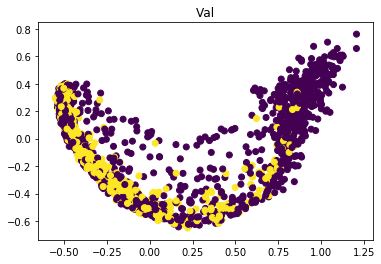

In [16]:
#nuevo test...

from sklearn.decomposition import PCA
dims_r = np.prod(x_train.shape[1:])
model = PCA(2)
plot_x = model.fit_transform(x_train.reshape([x_train.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_train, cmap='viridis') #morado es falso positivo
plt.title("train")
plt.show()

plot_x = model.transform(x_val.reshape([x_val.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_val, cmap='viridis') #morado es falso positivo
plt.title("Val")
plt.show()

Train on 8678 samples, validate on 1918 samples
Epoch 1/25
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5932 - acc: 0.6247 - val_loss: 0.5691 - val_acc: 0.6502
Epoch 2/25
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5751 - acc: 0.6289 - val_loss: 0.5595 - val_acc: 0.6502
Epoch 3/25
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5705 - acc: 0.6289 - val_loss: 0.5592 - val_acc: 0.6502
Epoch 4/25
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5692 - acc: 0.6277 - val_loss: 0.5648 - val_acc: 0.6502
Epoch 5/25
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5571 - acc: 0.6288 - val_loss: 0.5424 - val_acc: 0.6262
Epoch 6/25
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5431 - acc: 0.6345 - val_loss: 0.5261 - val_acc: 0.6548
Epoch 7/25
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5273 - acc: 0.6533 - val_loss: 0.5114 - val_acc: 0.6804
Epoch 8/25
86

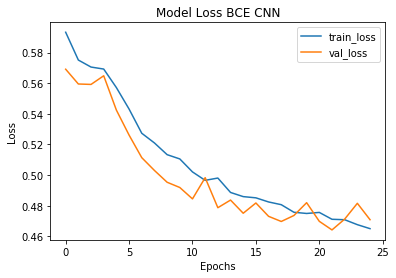

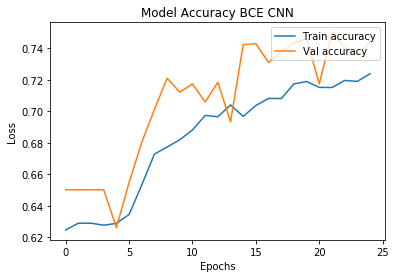

In [29]:
hist=model.fit(x_train, y_train, batch_size=128, epochs=25, verbose=1, validation_data=(x_val,y_val))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.785498,0.834002,0.809024,0.740046,0.710441,0.744004
Confirmed,0.651515,0.576751,0.611858,0.740046,0.710441,0.744004


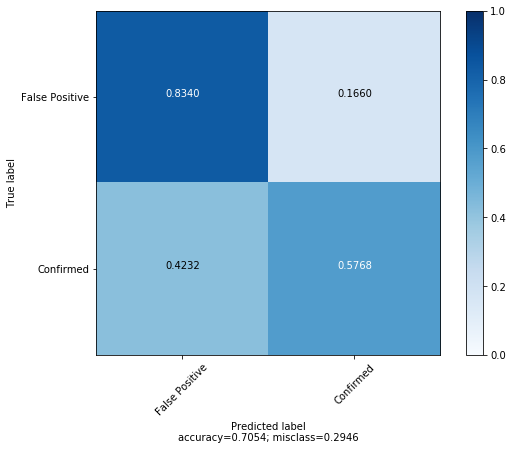

{'Precision raw': array([0.78549849, 0.65151515]), 'Recall raw': array([0.8340016 , 0.57675112]), 'F1 raw': array([0.80902373, 0.61185771]), 'F1 weighted': 0.7400464589579416, 'F1 macro': 0.7104407168432332, 'F1 micro': 0.7440041710114704, 'Confusion Matrix': array([[1040,  207],
       [ 284,  387]])}


In [30]:
predichos=model.predict_classes(x_val)
print (calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC'))

In [9]:
def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128):
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_data=(x_val,y_val))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    predichos=aux_model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

### Modelo 1

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 43, 43, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     


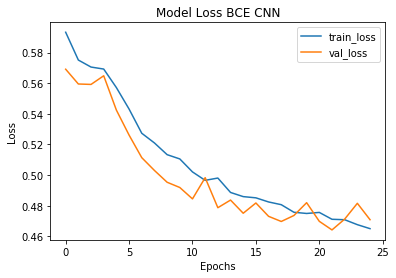

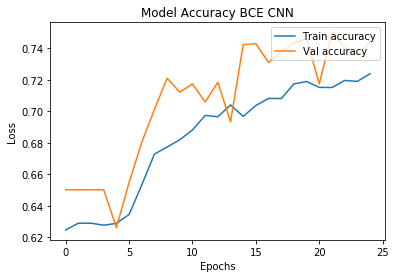

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.785498,0.834002,0.809024,0.740046,0.710441,0.744004
Confirmed,0.651515,0.576751,0.611858,0.740046,0.710441,0.744004


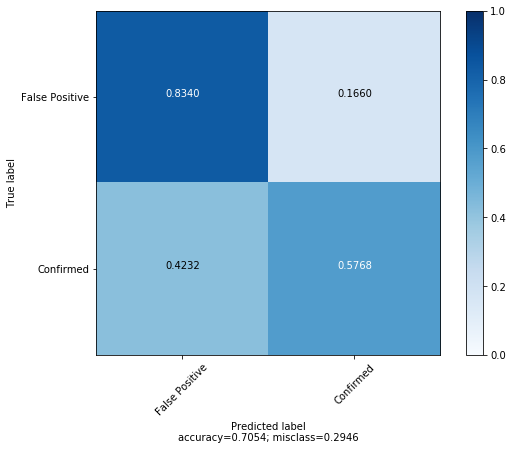

In [33]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5983 - acc: 0.6270 - val_loss: 0.5561 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 7s 829us/step - loss: 0.5701 - acc: 0.6289 - val_loss: 0.5630 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 8s 915us/step - loss: 0.5683 - acc: 0.6291 - val_loss: 0.5567 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 8s 886us/step - loss: 0.5585 - acc: 0.6289 - val_loss: 0.5419 - val_acc: 0.6481
Epoch 5/40
8678/8678 [==============================] - 8s 939us/step - loss: 0.5405 - acc: 0.6424 - val_loss: 0.5294 - val_acc: 0.6408
Epoch 6/40
8678/8678 [==============================] - 8s 893us/step - loss: 0.5276 - acc: 0.6599 - val_loss: 0.5136 - val_acc: 0.6747
Epoch 7/40
8678/8678 [==============================] - 8s 893us/step - loss: 0.5240 - acc: 0.6689 - val_loss: 0.5132 - val_acc: 0.6741
Ep

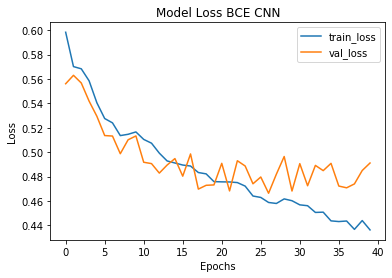

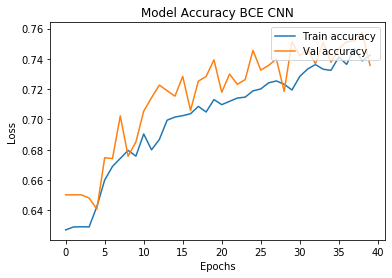

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.787714,0.812350,0.799842,0.733741,0.70537,0.735662
Confirmed,0.629747,0.593145,0.610898,0.733741,0.70537,0.735662


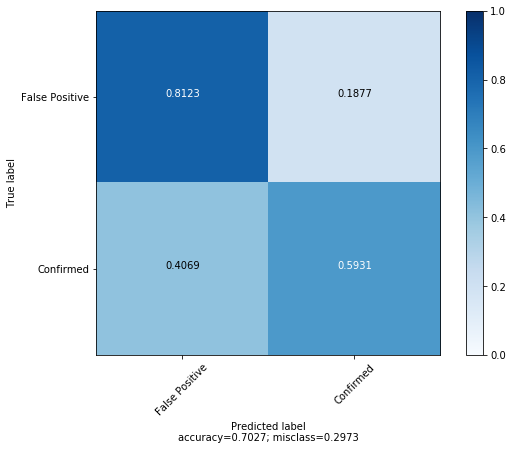

In [9]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

### Modelo 1 sobre viejo validation..

In [51]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)         

Train on 9384 samples, validate on 1565 samples
Epoch 1/25
9384/9384 [==============================] - 12s 1ms/step - loss: 0.5949 - acc: 0.6208 - val_loss: 0.6344 - val_acc: 0.6773
Epoch 2/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.5621 - acc: 0.6293 - val_loss: 0.5955 - val_acc: 0.5712
Epoch 3/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5539 - acc: 0.6395 - val_loss: 0.5980 - val_acc: 0.5553
Epoch 4/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5376 - acc: 0.6573 - val_loss: 0.5917 - val_acc: 0.5406
Epoch 5/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.5225 - acc: 0.6616 - val_loss: 0.5620 - val_acc: 0.6665
Epoch 6/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5018 - acc: 0.6848 - val_loss: 0.5730 - val_acc: 0.6837
Epoch 7/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.4969 - acc: 0.6894 - val_loss: 0.5612 - val_acc: 0.6907
Epoch 8

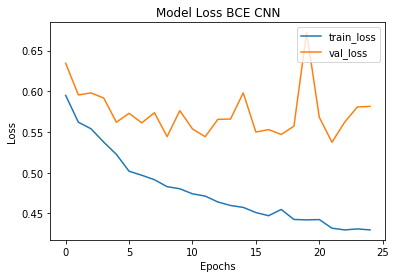

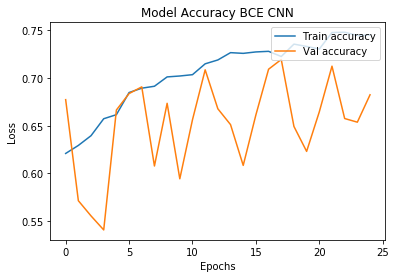

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.790506,0.722642,0.755052,0.688431,0.651822,0.682428
Confirmed,0.506711,0.598020,0.548592,0.688431,0.651822,0.682428


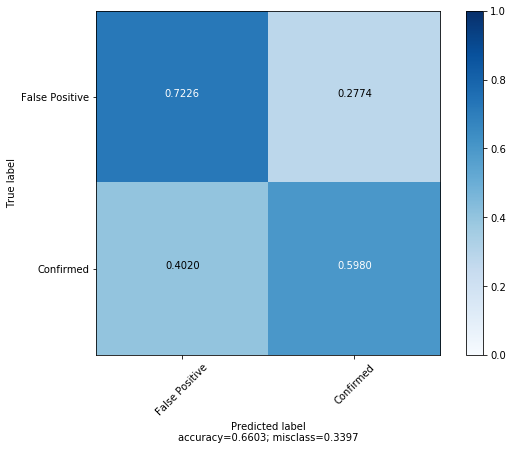

In [52]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

### Modelo 2

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 43, 43, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)         

Train on 9384 samples, validate on 1565 samples
Epoch 1/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5831 - acc: 0.6225 - val_loss: 0.6085 - val_acc: 0.5476
Epoch 2/25
9384/9384 [==============================] - 9s 914us/step - loss: 0.5499 - acc: 0.6498 - val_loss: 0.6199 - val_acc: 0.5176
Epoch 3/25
9384/9384 [==============================] - 9s 1ms/step - loss: 0.5228 - acc: 0.6639 - val_loss: 0.5645 - val_acc: 0.6863
Epoch 4/25
9384/9384 [==============================] - 9s 937us/step - loss: 0.5067 - acc: 0.6740 - val_loss: 0.5929 - val_acc: 0.5796
Epoch 5/25
9384/9384 [==============================] - 9s 962us/step - loss: 0.5004 - acc: 0.6801 - val_loss: 0.5689 - val_acc: 0.7010
Epoch 6/25
9384/9384 [==============================] - 9s 955us/step - loss: 0.4928 - acc: 0.6831 - val_loss: 0.5691 - val_acc: 0.7029
Epoch 7/25
9384/9384 [==============================] - 9s 976us/step - loss: 0.4851 - acc: 0.6988 - val_loss: 0.5712 - val_acc: 0.6709
Epo

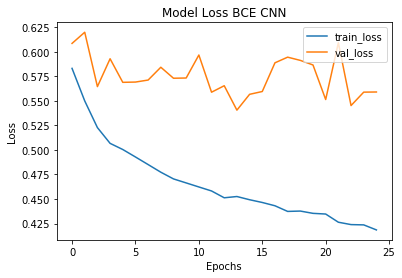

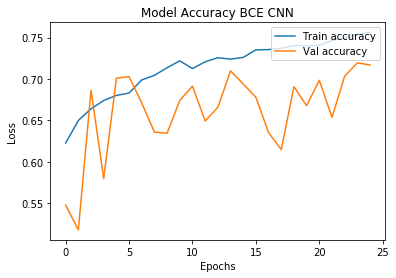

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.768494,0.833019,0.799457,0.708958,0.659229,0.716933
Confirmed,0.574519,0.473267,0.519001,0.708958,0.659229,0.716933


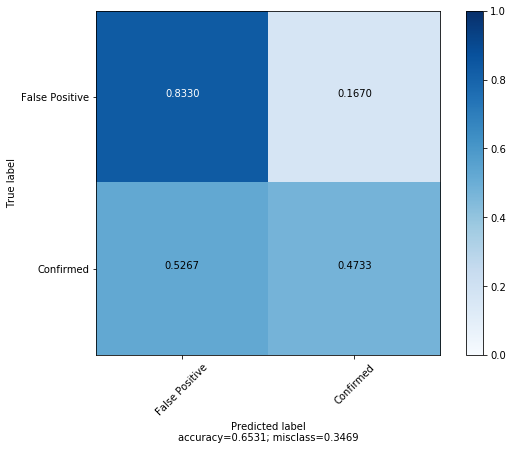

In [56]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 14s 2ms/step - loss: 0.5933 - acc: 0.6281 - val_loss: 0.5557 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5682 - acc: 0.6292 - val_loss: 0.5599 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5636 - acc: 0.6268 - val_loss: 0.5498 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5423 - acc: 0.6445 - val_loss: 0.5286 - val_acc: 0.6663
Epoch 5/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5306 - acc: 0.6546 - val_loss: 0.5178 - val_acc: 0.6924
Epoch 6/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5234 - acc: 0.6711 - val_loss: 0.5092 - val_acc: 0.7117
Epoch 7/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5210 - acc: 0.6777 - val_loss: 0.5060 - val_acc: 0.7091
Epoch 8

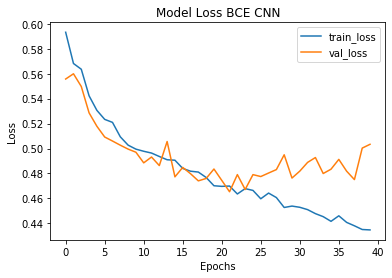

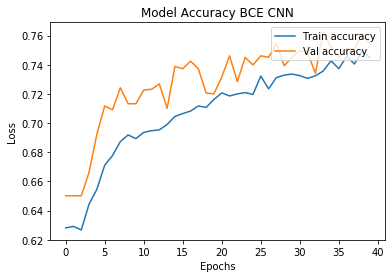

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.778577,0.868484,0.821077,0.745837,0.713543,0.75391
Confirmed,0.688805,0.540984,0.606010,0.745837,0.713543,0.75391


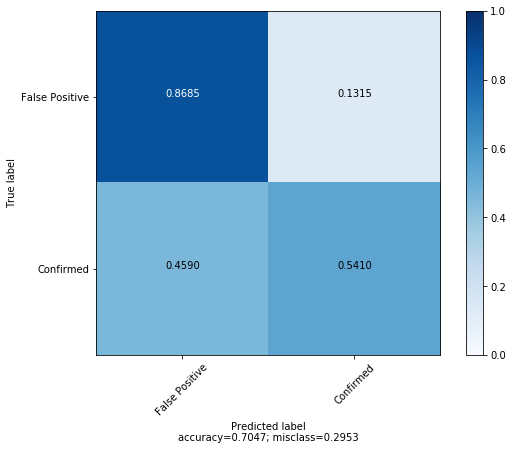

In [11]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

### Modelo 3

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)         

Train on 9384 samples, validate on 1565 samples
Epoch 1/25
9384/9384 [==============================] - 13s 1ms/step - loss: 0.5786 - acc: 0.6264 - val_loss: 0.5960 - val_acc: 0.5719
Epoch 2/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5510 - acc: 0.6447 - val_loss: 0.5718 - val_acc: 0.5674
Epoch 3/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.5240 - acc: 0.6555 - val_loss: 0.5669 - val_acc: 0.5661
Epoch 4/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.5085 - acc: 0.6711 - val_loss: 0.5722 - val_acc: 0.5572
Epoch 5/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5019 - acc: 0.6752 - val_loss: 0.5769 - val_acc: 0.5623
Epoch 6/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.4901 - acc: 0.6866 - val_loss: 0.5848 - val_acc: 0.6006
Epoch 7/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.4872 - acc: 0.6933 - val_loss: 0.5783 - val_acc: 0.6569
Epoch 8

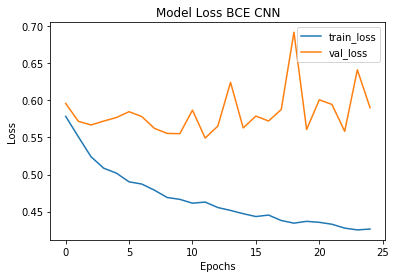

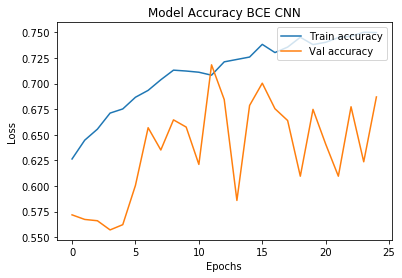

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.779961,0.749057,0.764196,0.689987,0.649208,0.686901
Confirmed,0.513711,0.556436,0.534221,0.689987,0.649208,0.686901


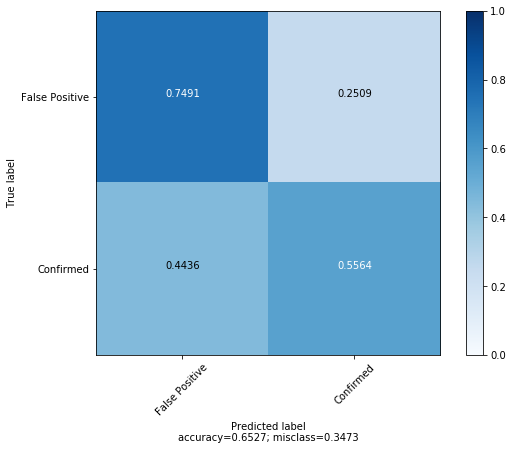

In [58]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.6096 - acc: 0.6279 - val_loss: 0.5595 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5713 - acc: 0.6289 - val_loss: 0.5523 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5606 - acc: 0.6316 - val_loss: 0.5421 - val_acc: 0.6335
Epoch 4/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5422 - acc: 0.6432 - val_loss: 0.5110 - val_acc: 0.6992
Epoch 5/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5258 - acc: 0.6602 - val_loss: 0.5097 - val_acc: 0.6804
Epoch 6/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5287 - acc: 0.6616 - val_loss: 0.5105 - val_acc: 0.6736
Epoch 7/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5169 - acc: 0.6755 - val_loss: 0.5020 - val_acc: 0.7075
Epoch 8

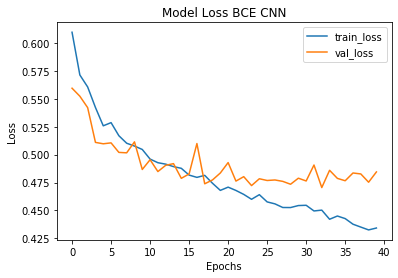

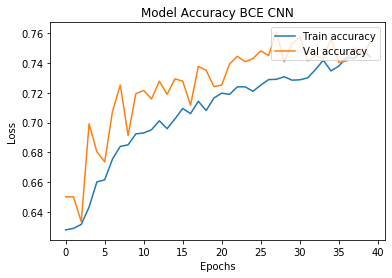

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.788806,0.847634,0.817163,0.74864,0.71923,0.753389
Confirmed,0.671280,0.578241,0.621297,0.74864,0.71923,0.753389


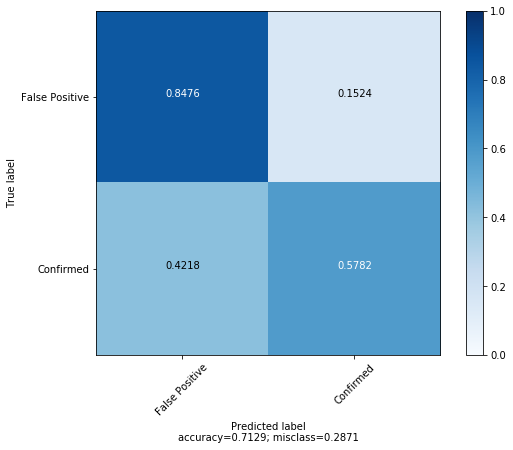

In [13]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

### Modelo 3 sin double

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 43, 43, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 19, 19, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 9, 64)         

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5903 - acc: 0.6288 - val_loss: 0.5568 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 7s 838us/step - loss: 0.5671 - acc: 0.6289 - val_loss: 0.5639 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 8s 873us/step - loss: 0.5641 - acc: 0.6289 - val_loss: 0.5540 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 8s 886us/step - loss: 0.5602 - acc: 0.6300 - val_loss: 0.5474 - val_acc: 0.6502
Epoch 5/40
8678/8678 [==============================] - 7s 854us/step - loss: 0.5547 - acc: 0.6293 - val_loss: 0.5490 - val_acc: 0.6408
Epoch 6/40
8678/8678 [==============================] - 7s 809us/step - loss: 0.5470 - acc: 0.6179 - val_loss: 0.5381 - val_acc: 0.6502
Epoch 7/40
8678/8678 [==============================] - 7s 816us/step - loss: 0.5445 - acc: 0.6235 - val_loss: 0.5443 - val_acc: 0.6502
Ep

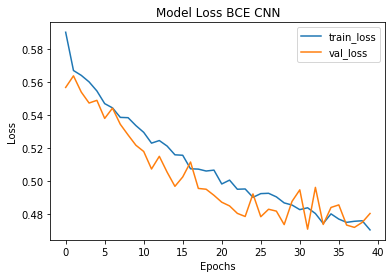

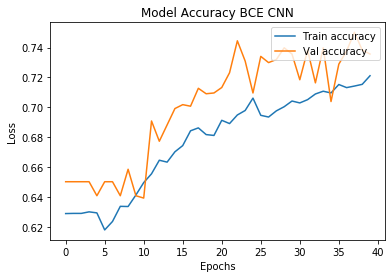

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.794586,0.800321,0.797443,0.735245,0.708549,0.735662
Confirmed,0.623867,0.615499,0.619655,0.735245,0.708549,0.735662


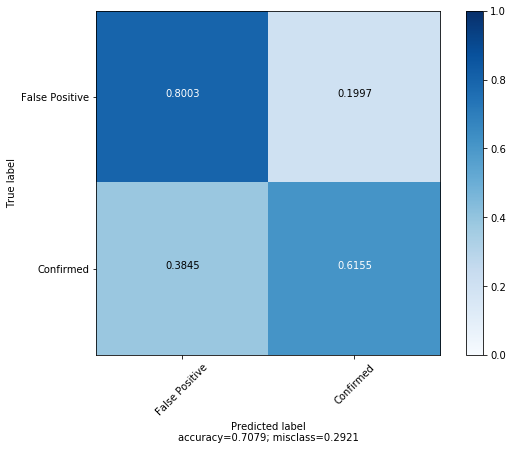

In [13]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #con global pooling (con dropa)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 39s 5ms/step - loss: 0.7357 - acc: 0.5945 - val_loss: 0.6016 - val_acc: 0.6048
Epoch 2/40
8678/8678 [==============================] - 35s 4ms/step - loss: 0.6261 - acc: 0.6142 - val_loss: 0.6138 - val_acc: 0.6267
Epoch 3/40
8678/8678 [==============================] - 35s 4ms/step - loss: 0.5889 - acc: 0.6363 - val_loss: 0.5421 - val_acc: 0.6522
Epoch 4/40
8678/8678 [==============================] - 33s 4ms/step - loss: 0.5751 - acc: 0.6376 - val_loss: 0.5290 - val_acc: 0.6726
Epoch 5/40
8678/8678 [==============================] - 33s 4ms/step - loss: 0.5709 - acc: 0.6414 - val_loss: 0.5285 - val_acc: 0.6898
Epoch 6/40
8678/8678 [==============================] - 34s 4ms/step - loss: 0.5564 - acc: 0.6470 - val_loss: 0.5308 - val_acc: 0.6460
Epoch 7/40
8678/8678 [==============================] - 34s 4ms/step - loss: 0.5507 - acc: 0.6480 - val_loss: 0.5231 - val_acc: 0.6778
Epoch 8

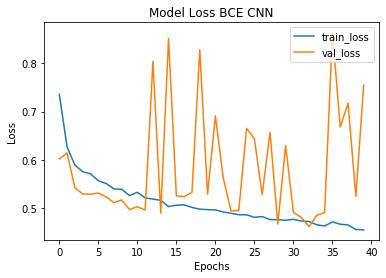

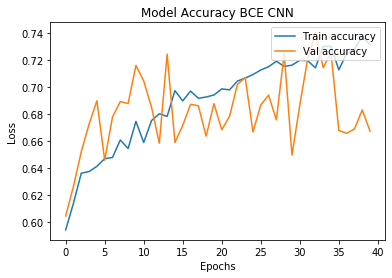

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.681358,0.917402,0.781955,0.612962,0.540428,0.667362
Confirmed,0.569038,0.202683,0.298901,0.612962,0.540428,0.667362


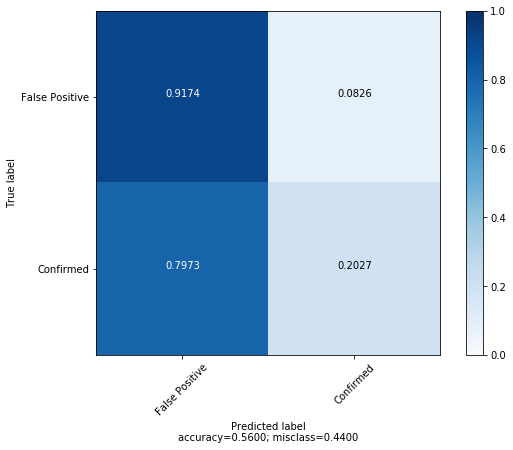

In [21]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #con global pooling con BN (con dropa)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 6s 719us/step - loss: 0.5899 - acc: 0.6251 - val_loss: 0.5544 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 4s 511us/step - loss: 0.5647 - acc: 0.6289 - val_loss: 0.5552 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 5s 568us/step - loss: 0.5587 - acc: 0.6289 - val_loss: 0.5480 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 5s 577us/step - loss: 0.5505 - acc: 0.6293 - val_loss: 0.5393 - val_acc: 0.6502
Epoch 5/40
8678/8678 [==============================] - 5s 540us/step - loss: 0.5470 - acc: 0.6247 - val_loss: 0.5403 - val_acc: 0.6293
Epoch 6/40
8678/8678 [==============================] - 5s 527us/step - loss: 0.5395 - acc: 0.6265 - val_loss: 0.5298 - val_acc: 0.6397
Epoch 7/40
8678/8678 [==============================] - 5s 560us/step - loss: 0.5315 - acc: 0.6382 - val_loss: 0.5238 - val_acc: 0.6434


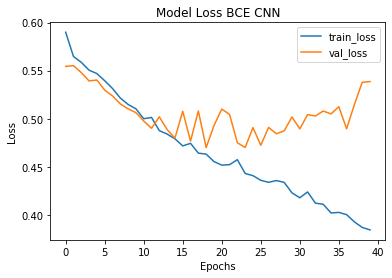

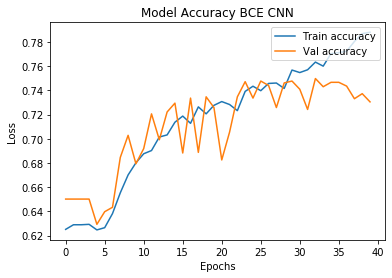

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.803156,0.775461,0.789066,0.732268,0.70789,0.730448
Confirmed,0.607843,0.646796,0.626715,0.732268,0.70789,0.730448


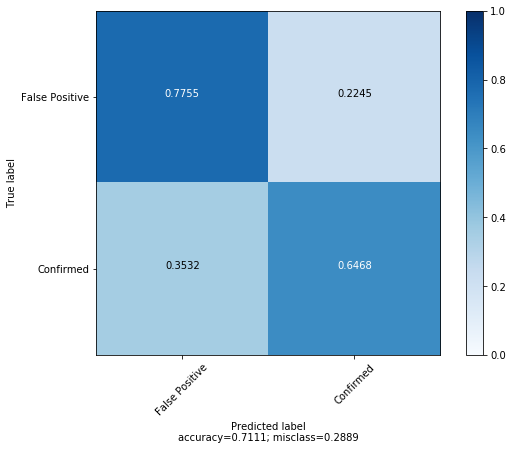

In [17]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #con global pooling sin dropa

### Modelo 2 (con Batch)

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 43, 43, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 41, 41, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 41, 41, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 18, 18, 64)      

Train on 9384 samples, validate on 1565 samples
Epoch 1/25
9384/9384 [==============================] - 52s 6ms/step - loss: 0.7276 - acc: 0.6115 - val_loss: 0.8024 - val_acc: 0.5093
Epoch 2/25
9384/9384 [==============================] - 47s 5ms/step - loss: 0.5960 - acc: 0.6436 - val_loss: 0.6618 - val_acc: 0.5150
Epoch 3/25
9384/9384 [==============================] - 46s 5ms/step - loss: 0.5520 - acc: 0.6674 - val_loss: 0.6471 - val_acc: 0.5367
Epoch 4/25
9384/9384 [==============================] - 44s 5ms/step - loss: 0.5323 - acc: 0.6724 - val_loss: 0.5971 - val_acc: 0.5898
Epoch 5/25
9384/9384 [==============================] - 45s 5ms/step - loss: 0.5105 - acc: 0.6903 - val_loss: 0.5779 - val_acc: 0.6000
Epoch 6/25
9384/9384 [==============================] - 47s 5ms/step - loss: 0.4968 - acc: 0.7017 - val_loss: 0.5444 - val_acc: 0.7016
Epoch 7/25
9384/9384 [==============================] - 45s 5ms/step - loss: 0.4861 - acc: 0.7041 - val_loss: 0.5904 - val_acc: 0.6307
Epoch 8

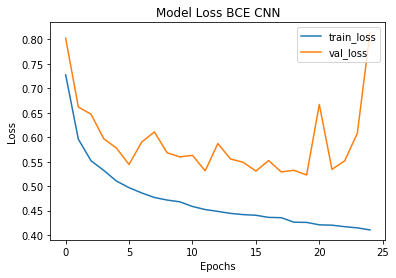

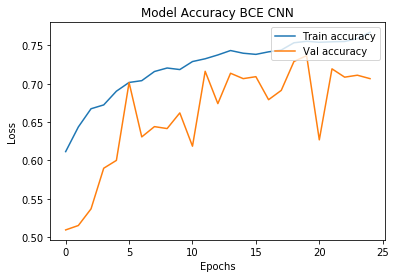

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.701273,0.987736,0.820212,0.621533,0.512359,0.706709
Confirmed,0.819444,0.116832,0.204506,0.621533,0.512359,0.706709


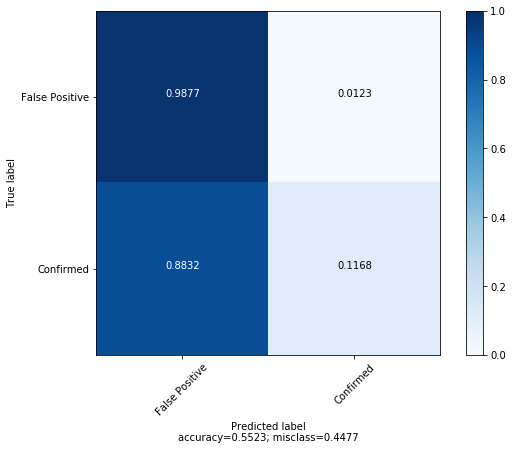

In [62]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 28s 3ms/step - loss: 0.7534 - acc: 0.5976 - val_loss: 0.6479 - val_acc: 0.6157
Epoch 2/40
8678/8678 [==============================] - 27s 3ms/step - loss: 0.6183 - acc: 0.6254 - val_loss: 0.7199 - val_acc: 0.6084
Epoch 3/40
8678/8678 [==============================] - 36s 4ms/step - loss: 0.5834 - acc: 0.6369 - val_loss: 0.5219 - val_acc: 0.6950
Epoch 4/40
8678/8678 [==============================] - 26s 3ms/step - loss: 0.5663 - acc: 0.6492 - val_loss: 0.5279 - val_acc: 0.6668
Epoch 5/40
8678/8678 [==============================] - 35s 4ms/step - loss: 0.5424 - acc: 0.6599 - val_loss: 0.4932 - val_acc: 0.7221
Epoch 6/40
8678/8678 [==============================] - 36s 4ms/step - loss: 0.5288 - acc: 0.6684 - val_loss: 0.4874 - val_acc: 0.7284
Epoch 7/40
8678/8678 [==============================] - 39s 5ms/step - loss: 0.5241 - acc: 0.6741 - val_loss: 0.4842 - val_acc: 0.7247
Epoch 8

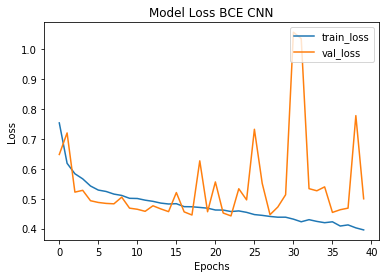

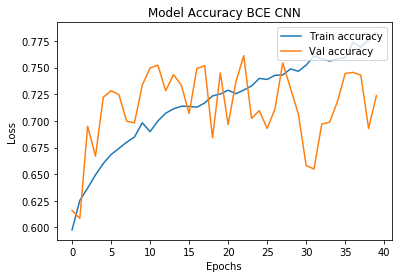

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.864700,0.681636,0.762332,0.730026,0.71616,0.72367
Confirmed,0.575401,0.801788,0.669988,0.730026,0.71616,0.72367


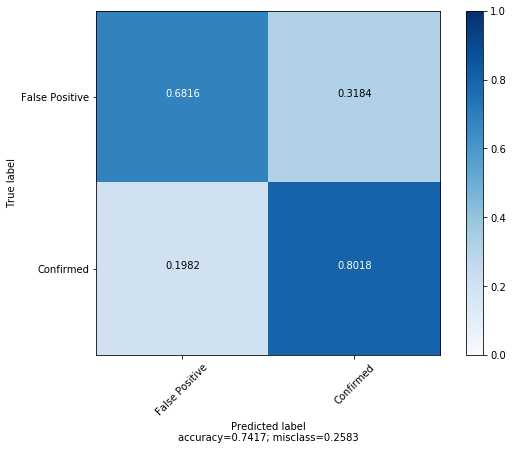

In [15]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

### Modelo 4

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 19, 19, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               331904    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)              

Train on 8678 samples, validate on 1918 samples
Epoch 1/25
8678/8678 [==============================] - 7s 792us/step - loss: 0.5861 - acc: 0.6187 - val_loss: 0.5417 - val_acc: 0.6502
Epoch 2/25
8678/8678 [==============================] - 3s 337us/step - loss: 0.5455 - acc: 0.6225 - val_loss: 0.5335 - val_acc: 0.6554
Epoch 3/25
8678/8678 [==============================] - 2s 261us/step - loss: 0.5395 - acc: 0.6326 - val_loss: 0.5278 - val_acc: 0.6595
Epoch 4/25
8678/8678 [==============================] - 2s 268us/step - loss: 0.5352 - acc: 0.6409 - val_loss: 0.5273 - val_acc: 0.6726
Epoch 5/25
8678/8678 [==============================] - 2s 278us/step - loss: 0.5301 - acc: 0.6518 - val_loss: 0.5207 - val_acc: 0.6700
Epoch 6/25
8678/8678 [==============================] - 2s 255us/step - loss: 0.5264 - acc: 0.6561 - val_loss: 0.5164 - val_acc: 0.6976
Epoch 7/25
8678/8678 [==============================] - 3s 336us/step - loss: 0.5247 - acc: 0.6617 - val_loss: 0.5146 - val_acc: 0.6851


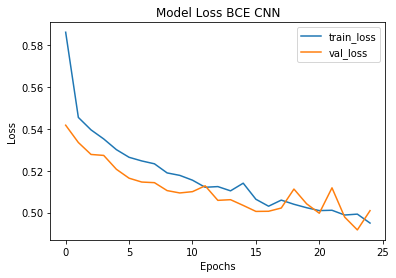

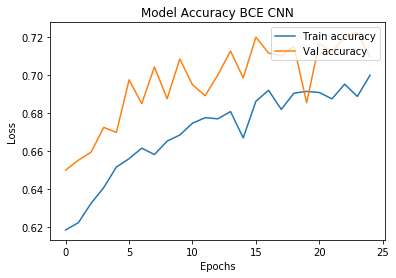

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.815934,0.714515,0.761864,0.715005,0.694893,0.709593
Confirmed,0.569007,0.700447,0.627923,0.715005,0.694893,0.709593


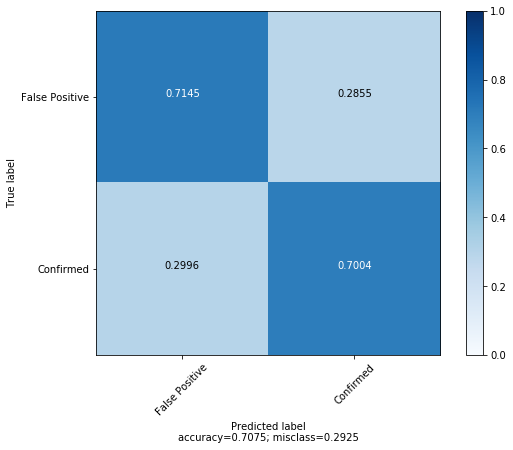

In [74]:
train_model(model, x_train, y_train, x_val, y_val, e=25) #old test

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 3s 366us/step - loss: 0.5820 - acc: 0.6162 - val_loss: 0.5443 - val_acc: 0.6382
Epoch 2/40
8678/8678 [==============================] - 2s 192us/step - loss: 0.5454 - acc: 0.6346 - val_loss: 0.5327 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 2s 195us/step - loss: 0.5367 - acc: 0.6429 - val_loss: 0.5238 - val_acc: 0.6637
Epoch 4/40
8678/8678 [==============================] - 2s 205us/step - loss: 0.5302 - acc: 0.6552 - val_loss: 0.5225 - val_acc: 0.6773
Epoch 5/40
8678/8678 [==============================] - 2s 203us/step - loss: 0.5269 - acc: 0.6625 - val_loss: 0.5134 - val_acc: 0.6809
Epoch 6/40
8678/8678 [==============================] - 2s 226us/step - loss: 0.5209 - acc: 0.6719 - val_loss: 0.5192 - val_acc: 0.6747
Epoch 7/40
8678/8678 [==============================] - 4s 439us/step - loss: 0.5216 - acc: 0.6702 - val_loss: 0.5082 - val_acc: 0.6903


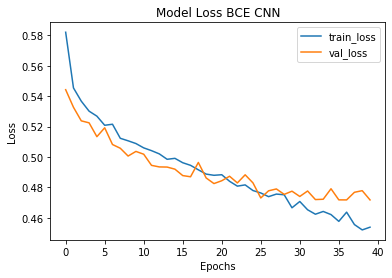

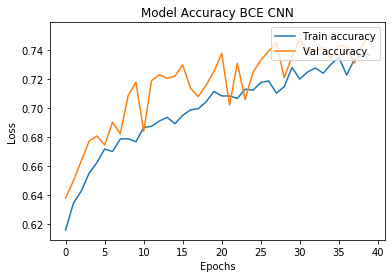

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.764022,0.895750,0.824659,0.738551,0.701593,0.752346
Confirmed,0.714912,0.485842,0.578527,0.738551,0.701593,0.752346


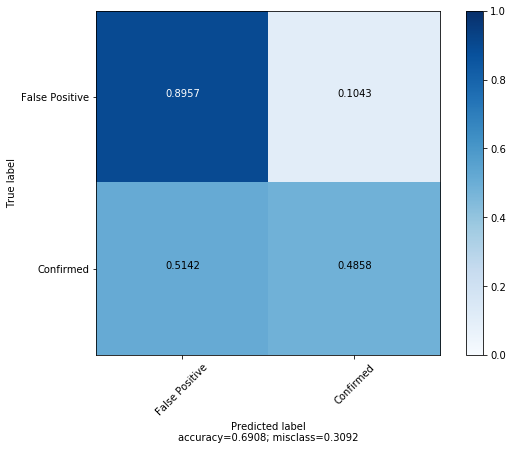

In [17]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

In [20]:
## experimetanciones varias -- modelo 1
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 5, 5, 256)         295168    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)              

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 8s 918us/step - loss: 0.5955 - acc: 0.6251 - val_loss: 0.5648 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 6s 722us/step - loss: 0.5661 - acc: 0.6289 - val_loss: 0.5532 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 6s 725us/step - loss: 0.5633 - acc: 0.6291 - val_loss: 0.5556 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 6s 698us/step - loss: 0.5615 - acc: 0.6286 - val_loss: 0.5573 - val_acc: 0.6502
Epoch 5/40
8678/8678 [==============================] - 6s 711us/step - loss: 0.5569 - acc: 0.6289 - val_loss: 0.5483 - val_acc: 0.6502
Epoch 6/40
8678/8678 [==============================] - 6s 717us/step - loss: 0.5595 - acc: 0.6227 - val_loss: 0.5759 - val_acc: 0.6502
Epoch 7/40
8678/8678 [==============================] - 6s 675us/step - loss: 0.5564 - acc: 0.6271 - val_loss: 0.5476 - val_acc: 0.6220


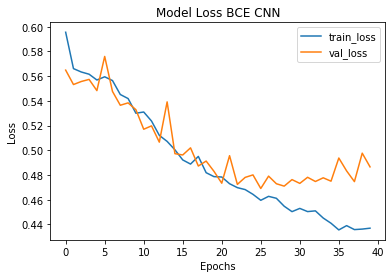

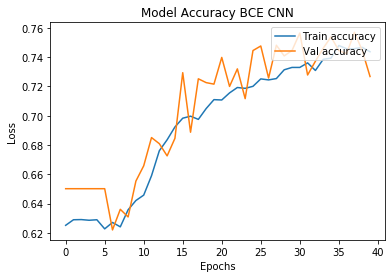

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.796555,0.778669,0.787510,0.72804,0.702514,0.726799
Confirmed,0.605150,0.630402,0.617518,0.72804,0.702514,0.726799


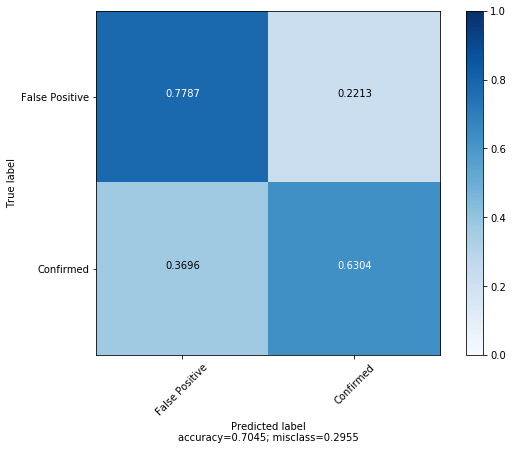

In [21]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

In [ ]:
* sin dropa-- ña
* sin double --ayuda a regularizar (mas simple)
* con bn? -- no


In [29]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 7, 128)       

Train on 8678 samples, validate on 1918 samples
Epoch 1/100
8678/8678 [==============================] - 12s 1ms/step - loss: 0.6013 - acc: 0.6286 - val_loss: 0.5590 - val_acc: 0.6502
Epoch 2/100
8678/8678 [==============================] - 6s 682us/step - loss: 0.5690 - acc: 0.6289 - val_loss: 0.5589 - val_acc: 0.6502
Epoch 3/100
8678/8678 [==============================] - 6s 676us/step - loss: 0.5654 - acc: 0.6289 - val_loss: 0.5573 - val_acc: 0.6502
Epoch 4/100
8678/8678 [==============================] - 6s 688us/step - loss: 0.5646 - acc: 0.6289 - val_loss: 0.5499 - val_acc: 0.6502
Epoch 5/100
8678/8678 [==============================] - 6s 698us/step - loss: 0.5573 - acc: 0.6286 - val_loss: 0.5543 - val_acc: 0.6502
Epoch 6/100
8678/8678 [==============================] - 6s 644us/step - loss: 0.5575 - acc: 0.6289 - val_loss: 0.5414 - val_acc: 0.6502
Epoch 7/100
8678/8678 [==============================] - 6s 682us/step - loss: 0.5557 - acc: 0.6292 - val_loss: 0.5442 - val_acc: 0

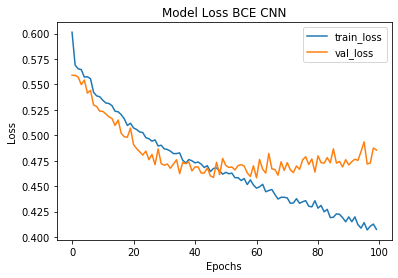

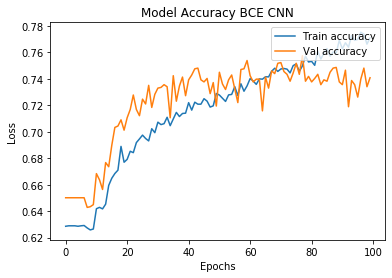

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.761872,0.874900,0.814483,0.729106,0.692462,0.740876
Confirmed,0.679012,0.491803,0.570441,0.729106,0.692462,0.740876


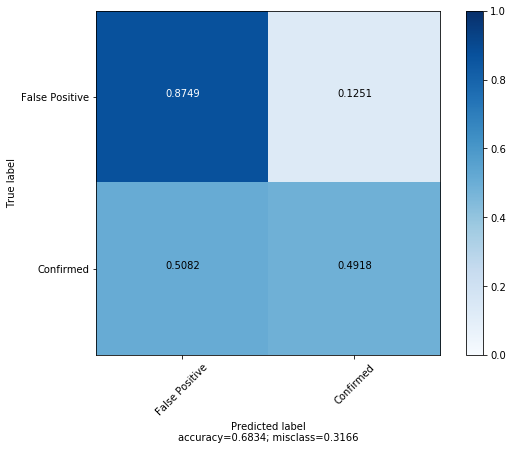

In [30]:
train_model(model, x_train, y_train, x_val, y_val, e=100) #modelo 2 sin double sin BN

In [116]:
#rnn por fila luego  cnn

model = Sequential()
model.add(InputLayer(input_shape=x_train.shape[1:]))
#model.add(Lambda(lambda x: K.squeeze(x, axis=-1)))

model.add(TimeDistributed(GRU(32, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(TimeDistributed(GRU(32, activation='relu', return_sequences=False)))
model.add(Dropout(0.2))

model.add(Lambda(lambda x: K.expand_dims(x, axis=-1)))
model.add(Conv2D(16, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))


model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 45, 45, 32)        3264      
_________________________________________________________________
dropout_100 (Dropout)        (None, 45, 45, 32)        0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 45, 32)            6240      
_________________________________________________________________
dropout_101 (Dropout)        (None, 45, 32)            0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 45, 32, 1)         0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 43, 30, 16)        160       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 21, 15, 16)      

In [117]:
train_model(model, x_train, y_train, x_val, y_val, e=25) #old test

Train on 8678 samples, validate on 1918 samples
Epoch 1/25
 384/8678 [>.............................] - ETA: 4:45 - loss: 0.6926 - acc: 0.5885

KeyboardInterrupt: 

In [ ]:
##skip connection
https://stackoverflow.com/questions/42384602/implementing-skip-connections-in-keras

## mejor modelo con focal loss

In [118]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.79497985 1.34751553]


In [22]:
import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [37]:
## experimetanciones varias -- modelo 1
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.6, gamma=2),optimizer='Adam',metrics=['accuracy'])
#model.compile(loss=binary_focal_loss(alpha=.25, gamma=2),optimizer='Adam',metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 1, 1, 256)       

Train on 8678 samples, validate on 1918 samples
Epoch 1/25
8678/8678 [==============================] - 10s 1ms/step - loss: 7.8582 - acc: 0.6272 - val_loss: 7.2536 - val_acc: 0.6502
Epoch 2/25
8678/8678 [==============================] - 4s 505us/step - loss: 7.4764 - acc: 0.6289 - val_loss: 7.2686 - val_acc: 0.6502
Epoch 3/25
8678/8678 [==============================] - 5s 532us/step - loss: 7.4217 - acc: 0.6289 - val_loss: 7.2570 - val_acc: 0.6502
Epoch 4/25
8678/8678 [==============================] - 5s 578us/step - loss: 7.4512 - acc: 0.6289 - val_loss: 7.2085 - val_acc: 0.6502
Epoch 5/25
8678/8678 [==============================] - 5s 549us/step - loss: 7.3838 - acc: 0.6289 - val_loss: 7.2265 - val_acc: 0.6502
Epoch 6/25
8678/8678 [==============================] - 5s 562us/step - loss: 7.3495 - acc: 0.6289 - val_loss: 7.1659 - val_acc: 0.6502
Epoch 7/25
8678/8678 [==============================] - 5s 539us/step - loss: 7.3308 - acc: 0.6289 - val_loss: 7.3480 - val_acc: 0.6502
E

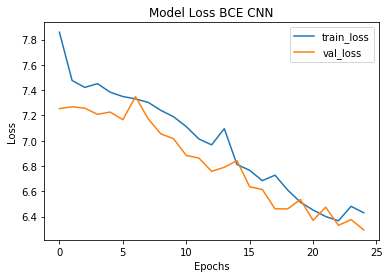

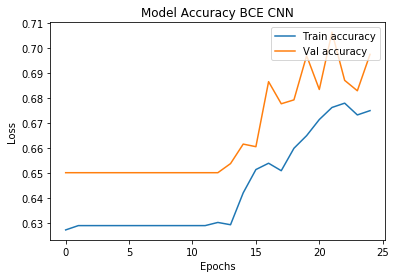

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.685175,0.989575,0.809711,0.618783,0.536835,0.697602
Confirmed,0.888889,0.154993,0.263959,0.618783,0.536835,0.697602


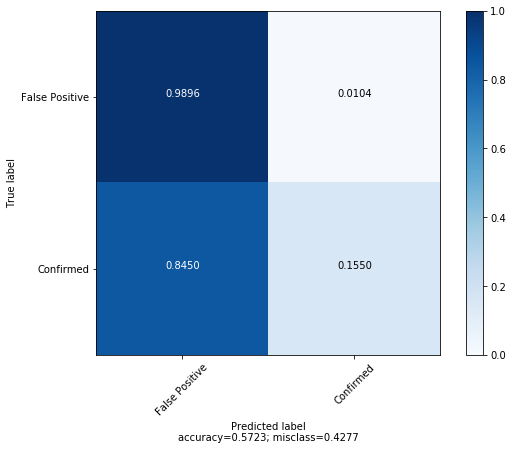

In [126]:
train_model(model, x_train, y_train, x_val, y_val, e=25) #old test

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 8s 919us/step - loss: 9.1263 - acc: 0.6102 - val_loss: 8.8737 - val_acc: 0.6215
Epoch 2/40
8678/8678 [==============================] - 5s 602us/step - loss: 8.7359 - acc: 0.6136 - val_loss: 8.6955 - val_acc: 0.5980
Epoch 3/40
8678/8678 [==============================] - 5s 609us/step - loss: 8.4822 - acc: 0.6263 - val_loss: 8.3619 - val_acc: 0.6303
Epoch 4/40
8678/8678 [==============================] - 5s 602us/step - loss: 8.2997 - acc: 0.6372 - val_loss: 8.3778 - val_acc: 0.6444
Epoch 5/40
8678/8678 [==============================] - 5s 584us/step - loss: 8.2308 - acc: 0.6369 - val_loss: 8.2992 - val_acc: 0.6491
Epoch 6/40
8678/8678 [==============================] - 5s 572us/step - loss: 8.1035 - acc: 0.6442 - val_loss: 8.2720 - val_acc: 0.6210
Epoch 7/40
8678/8678 [==============================] - 5s 564us/step - loss: 8.0032 - acc: 0.6457 - val_loss: 8.0358 - val_acc: 0.6585


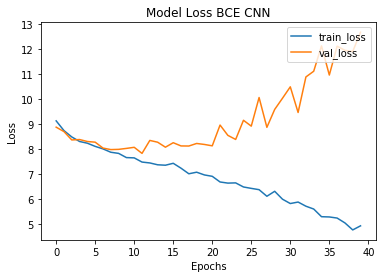

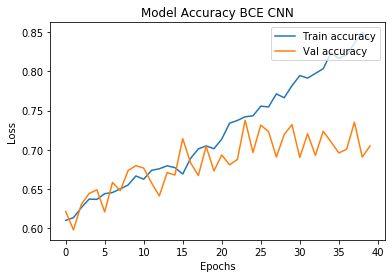

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.838806,0.676022,0.748668,0.711588,0.695672,0.704901
Confirmed,0.557503,0.758569,0.642677,0.711588,0.695672,0.704901


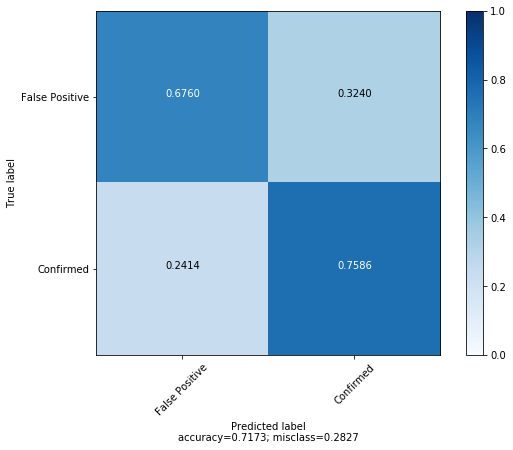

In [38]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #alpha alto

In [30]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.65, gamma=2),optimizer='Adam',metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 2, 2, 256)       

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 7s 816us/step - loss: 9.1458 - acc: 0.6072 - val_loss: 8.8507 - val_acc: 0.6001
Epoch 2/40
8678/8678 [==============================] - 4s 499us/step - loss: 8.8724 - acc: 0.6058 - val_loss: 8.8238 - val_acc: 0.5876
Epoch 3/40
8678/8678 [==============================] - 4s 465us/step - loss: 8.7931 - acc: 0.6091 - val_loss: 8.6164 - val_acc: 0.6220
Epoch 4/40
8678/8678 [==============================] - 4s 496us/step - loss: 8.6192 - acc: 0.6136 - val_loss: 8.4468 - val_acc: 0.6267
Epoch 5/40
8678/8678 [==============================] - 5s 558us/step - loss: 8.4712 - acc: 0.6291 - val_loss: 8.4116 - val_acc: 0.6246
Epoch 6/40
8678/8678 [==============================] - 5s 600us/step - loss: 8.3290 - acc: 0.6338 - val_loss: 8.4866 - val_acc: 0.6413
Epoch 7/40
8678/8678 [==============================] - 5s 550us/step - loss: 8.2556 - acc: 0.6383 - val_loss: 8.3096 - val_acc: 0.6230


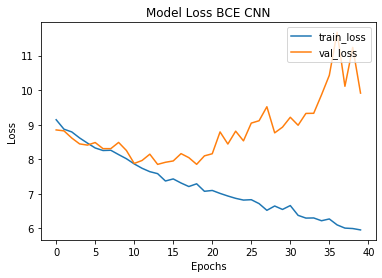

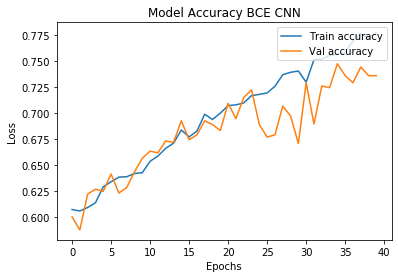

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.811973,0.772253,0.791615,0.738095,0.715123,0.735662
Confirmed,0.612022,0.667660,0.638632,0.738095,0.715123,0.735662


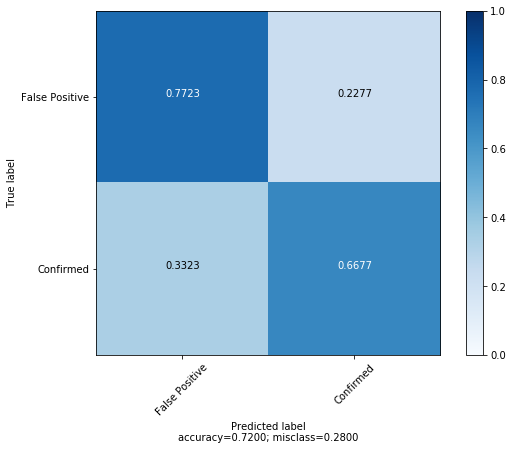

In [24]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #alpha 0.6

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 7s 848us/step - loss: 8.8709 - acc: 0.5982 - val_loss: 8.5833 - val_acc: 0.5923
Epoch 2/40
8678/8678 [==============================] - 5s 543us/step - loss: 8.5931 - acc: 0.6036 - val_loss: 8.4192 - val_acc: 0.6074
Epoch 3/40
8678/8678 [==============================] - 5s 529us/step - loss: 8.3736 - acc: 0.6164 - val_loss: 8.2326 - val_acc: 0.6168
Epoch 4/40
8678/8678 [==============================] - 5s 544us/step - loss: 8.2544 - acc: 0.6211 - val_loss: 8.5717 - val_acc: 0.6309
Epoch 5/40
8678/8678 [==============================] - 4s 511us/step - loss: 8.1764 - acc: 0.6240 - val_loss: 8.1699 - val_acc: 0.6189
Epoch 6/40
8678/8678 [==============================] - 5s 537us/step - loss: 7.9522 - acc: 0.6355 - val_loss: 8.1196 - val_acc: 0.6074
Epoch 7/40
8678/8678 [==============================] - 5s 563us/step - loss: 7.8664 - acc: 0.6356 - val_loss: 7.8197 - val_acc: 0.6434


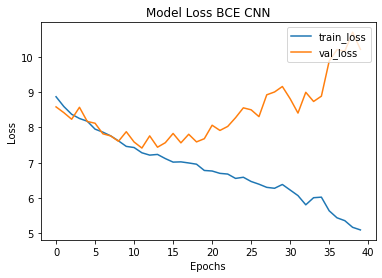

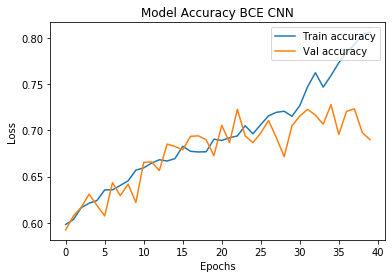

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.899510,0.588613,0.711585,0.695081,0.687998,0.689781
Confirmed,0.534483,0.877794,0.664411,0.695081,0.687998,0.689781


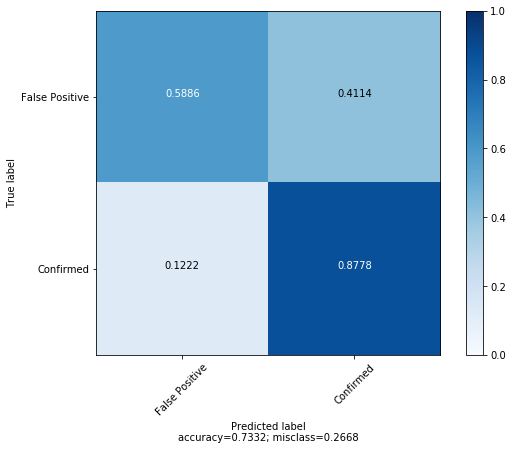

In [31]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #alpha 0.65

### Concat

In [42]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.7, gamma=2),optimizer='Adam',metrics=['accuracy'])
#model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 43, 43, 32)        608       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 2, 2, 256)       

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 5s 1ms/step - loss: 0.6030 - acc: 0.6269 - val_loss: 0.5684 - val_acc: 0.6502
Epoch 2/40
4339/4339 [==============================] - 2s 565us/step - loss: 0.5706 - acc: 0.6289 - val_loss: 0.5590 - val_acc: 0.6502
Epoch 3/40
4339/4339 [==============================] - 3s 614us/step - loss: 0.5648 - acc: 0.6289 - val_loss: 0.5532 - val_acc: 0.6502
Epoch 4/40
4339/4339 [==============================] - 2s 412us/step - loss: 0.5588 - acc: 0.6289 - val_loss: 0.5522 - val_acc: 0.6502
Epoch 5/40
4339/4339 [==============================] - 2s 495us/step - loss: 0.5619 - acc: 0.6306 - val_loss: 0.5593 - val_acc: 0.6502
Epoch 6/40
4339/4339 [==============================] - 2s 442us/step - loss: 0.5539 - acc: 0.6283 - val_loss: 0.5422 - val_acc: 0.6502
Epoch 7/40
4339/4339 [==============================] - 2s 413us/step - loss: 0.5487 - acc: 0.6269 - val_loss: 0.5354 - val_acc: 0.6502
Ep

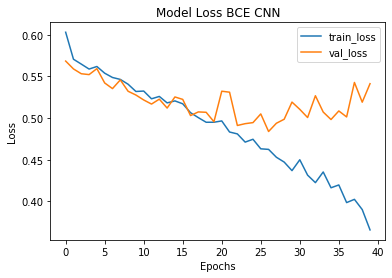

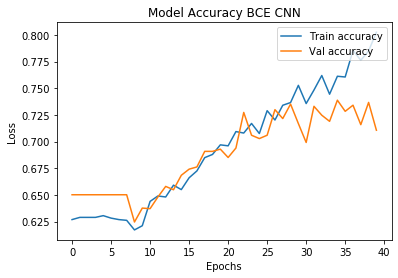

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.832692,0.694467,0.757324,0.716875,0.699514,0.710636
Confirmed,0.566059,0.740686,0.641704,0.716875,0.699514,0.710636


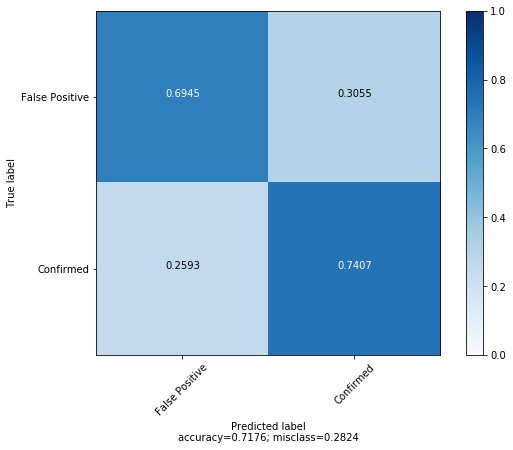

In [39]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #sin focal

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 5s 1ms/step - loss: 8.7856 - acc: 0.5822 - val_loss: 8.2377 - val_acc: 0.5777
Epoch 2/40
4339/4339 [==============================] - 2s 400us/step - loss: 8.2679 - acc: 0.5902 - val_loss: 8.1341 - val_acc: 0.5865
Epoch 3/40
4339/4339 [==============================] - 2s 540us/step - loss: 8.1871 - acc: 0.5939 - val_loss: 8.2782 - val_acc: 0.5589
Epoch 4/40
4339/4339 [==============================] - 2s 551us/step - loss: 8.2392 - acc: 0.5937 - val_loss: 8.0549 - val_acc: 0.5918
Epoch 5/40
4339/4339 [==============================] - 2s 543us/step - loss: 8.0678 - acc: 0.6047 - val_loss: 7.9819 - val_acc: 0.6038
Epoch 6/40
4339/4339 [==============================] - 2s 554us/step - loss: 8.0079 - acc: 0.6052 - val_loss: 7.9879 - val_acc: 0.5975
Epoch 7/40
4339/4339 [==============================] - 2s 509us/step - loss: 7.8939 - acc: 0.6121 - val_loss: 7.9478 - val_acc: 0.5985
Ep

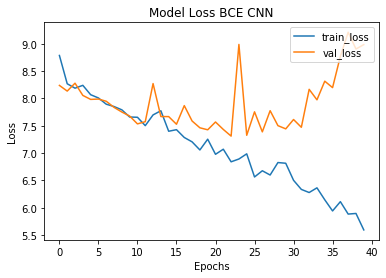

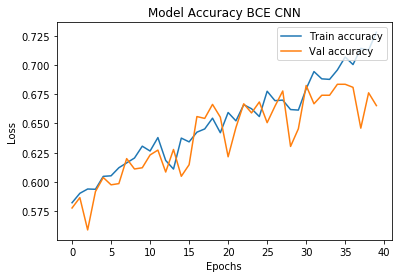

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.961832,0.505213,0.662461,0.664414,0.665253,0.665276
Confirmed,0.511481,0.962742,0.668046,0.664414,0.665253,0.665276


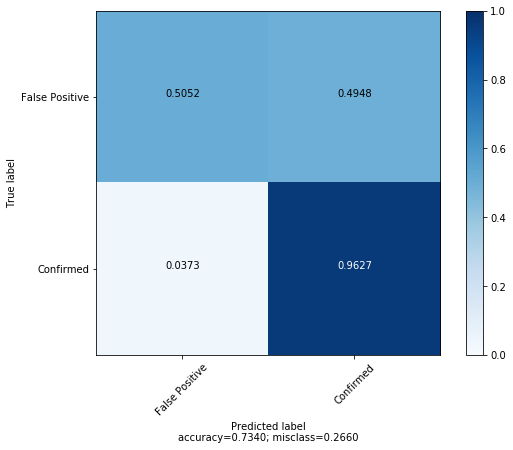

In [43]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #alpha 0.6